In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve
import starry

In [3]:
# Degree of the Ylm expansion
lmax = 20
N = (lmax + 1) ** 2

In [73]:
# Grab the `A1` matrix from `starry`
map = starry.Map(lmax, lazy=False)
A1 = map.ops.A1.eval()
A = map.ops.A.eval()
A2Inv = np.dot(A1.todense(), np.linalg.inv(A.todense()))

In [153]:
def Ij(j, gamma):
    """
    
    """
    if j == 0:
        return 0.5 * np.pi * (1 - gamma ** 2)
    else:
        return (j - 1) / (j + 2) * (1 - gamma ** 2) * Ij(j - 2, gamma)

    
def spn(n, xi, wsini):
    """
    s_n in the poly basis
    
    """
    # This is a vector function!
    xi = np.atleast_1d(xi)
    res = np.zeros_like(xi)
    
    # Indices
    L = np.floor(np.sqrt(n))
    D = 0.5 * (n - L ** 2)
    i = int(np.floor(L - D))
    j = int(np.floor(D))
    k = int(np.ceil(D) - np.floor(D))
    
    # x coordinate of lines of constant Doppler shift
    gamma = 1 / wsini * (1 - np.exp(xi))
    
    # Integral is only nonzero when we're
    # inside the unit disk
    idx = np.abs(gamma) < 1

    # Solve the integral
    if (k == 0) and (j % 2 == 0):
        res[idx] = (2 * gamma[idx] ** i * (1 - gamma[idx] ** 2) ** (0.5 * (j + 1))) / (j + 1)
    elif (k == 1) and (j % 2 == 0):
        res[idx] = gamma[idx] ** i * Ij(j, gamma[idx])
    
    return res


def sn(n, xi, wsini):
    """
    s_n in the greens basis
    """
    sp = np.zeros((N, len(xi)))
    for k in range(N):
        sp[k] = spn(k, xi, wsini)
    
    return np.array(np.dot(sp.T, A2Inv)[:, n]).reshape(-1)

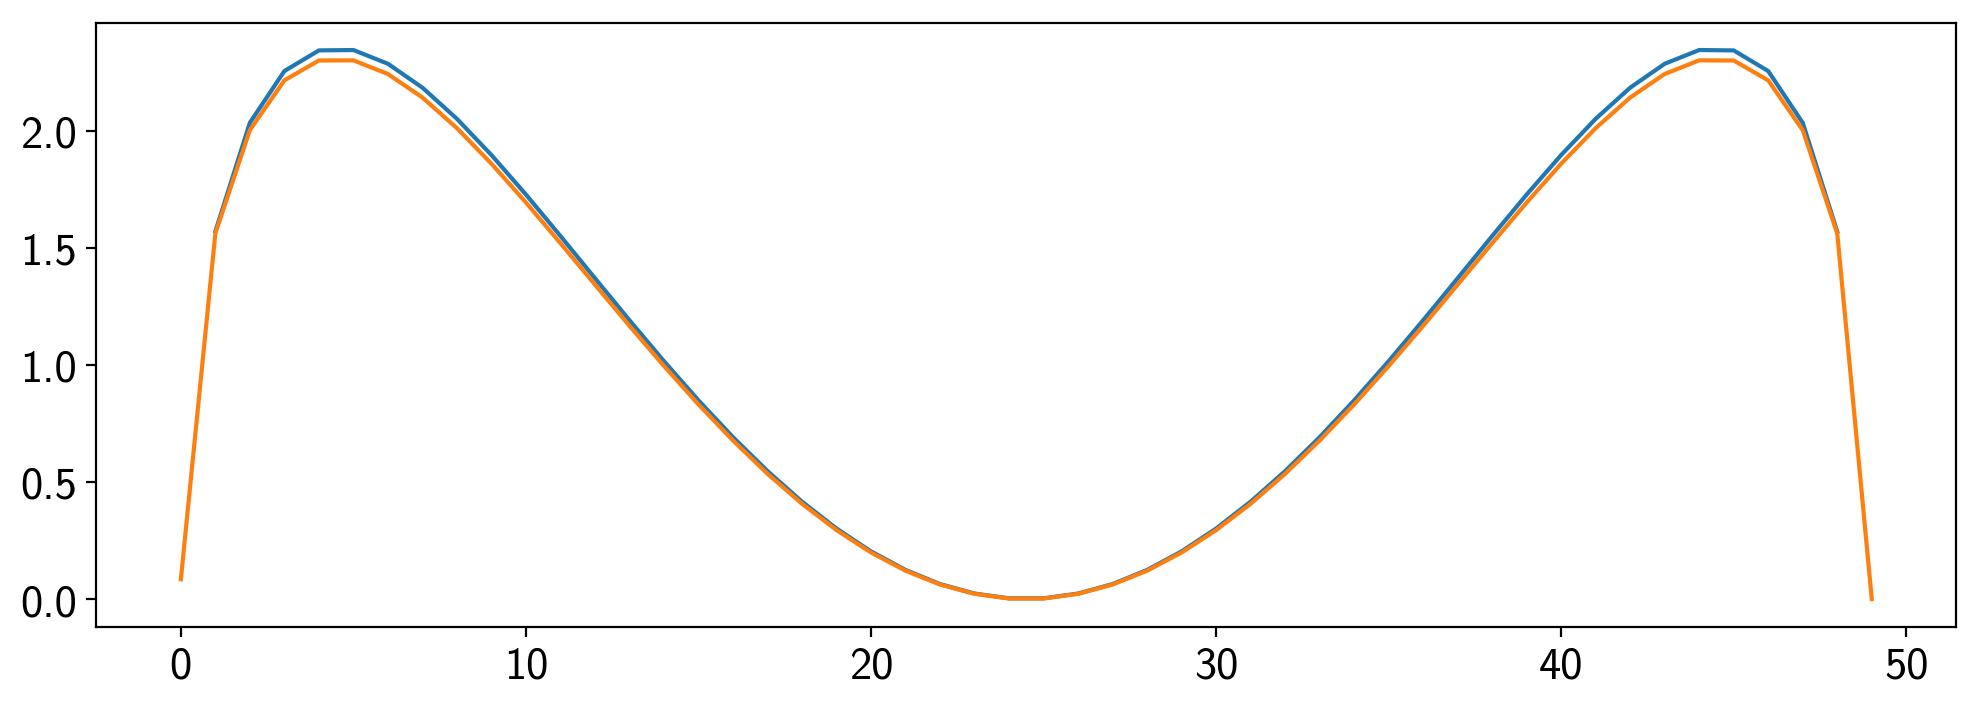

In [163]:
wsini = 1e-4
nzeta = 50
maxD = np.log(1 + wsini)
zeta = np.linspace(-maxD, maxD, nzeta)

s4 = sn(4, zeta, -wsini)


# g4 = 3 * x ** 2
# G4 = (0, x ** 3)


x = 1 / wsini * (1 - np.exp(zeta))
dx = x[1] - x[0]
xL = x - 0.5 * dx
xR = x + 0.5 * dx
I1 = 2 * xL ** 3 * np.sqrt(1 - xL ** 2)
I3 = -2 * xR ** 3 * np.sqrt(1 - xR ** 2)
phi = np.arctan2(np.sqrt(1 - xL ** 2), xL)
A = 3 * phi / 8. + 1 / 4. * np.sin(2 * phi) + 1 / 32. * np.sin(4 * phi)
phi = np.arctan2(np.sqrt(1 - xR ** 2), xR)
B = 3 * phi / 8. + 1 / 4. * np.sin(2 * phi) + 1 / 32. * np.sin(4 * phi)
I2 = B - A
I4 = I2
s4_gr = (I1 + I2 + I3 + I4) * 0.5 * nzeta

plt.plot(s4_gr)
plt.plot(s4)

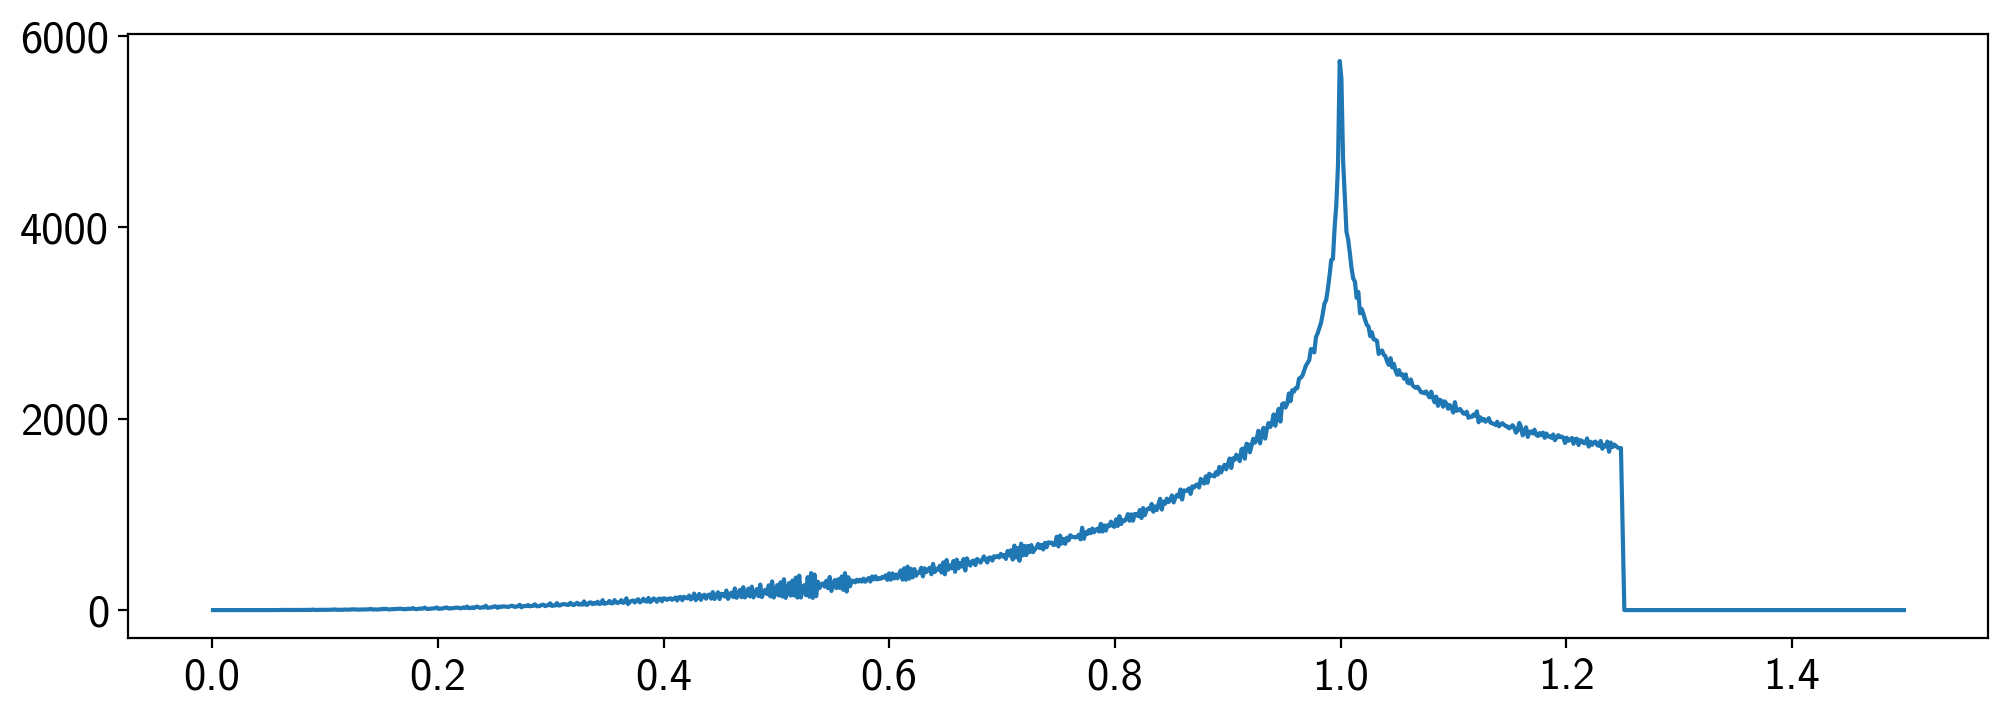

In [199]:
x = np.linspace(-1, 1, 1000)
y = np.linspace(-1, 1, 1000)
x, y = np.meshgrid(x, y)
z = np.sqrt(1 - x ** 2 - y ** 2)
Y = x ** 2 * y ** 2 * z
D = x ** 2 + z

inside = x.flatten() ** 2 + y.flatten() ** 2 <= 1

Y = Y.flatten()[inside]
D = D.flatten()[inside]
bins = np.linspace(0, 1.5, 1000)

plt.figure()
f, x = np.histogram(D, weights=D, bins=bins)
x = (x[1:] + x[:-1]) / 2
plt.plot(x, f)